In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from scipy.special import logsumexp


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna

In [111]:
def ilr_transform(X):
    epsilon = 1e-10
    X = X + epsilon
    return np.log(X / np.mean(X, axis=1, keepdims=True))

pcos = pd.read_csv("../data/t2d/clean.csv")
data = pcos.iloc[:, 4:].values
X_ilr = ilr_transform(data)

labels = pcos.iloc[:, 1].values

In [115]:
X_tensor = torch.tensor(X_ilr, dtype=torch.float32)

In [133]:
#our latent dimension --> z_dim
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, z_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, z_dim)
        #self.fc3 = nn.Linear(latent_dim, hidden_dim)
        #self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        mean = self.fc2_mean(h1)
        logvar = self.fc2_logvar(h1)
        return mean, logvar

In [135]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, z):
        h1= torch.relu(self.fc1(z))
        return self.softmax(self.fc2(h1))

In [137]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

In [151]:
def vae_loss(recon_x, x, mean, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return MSE + KLD

In [157]:
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    latent_dim = trial.suggest_categorical('latent_dim', [10, 20, 50])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)

    model = VAE(input_dim=45, hidden_dim=hidden_dim, z_dim=latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    writer = SummaryWriter(log_dir=f'runs/optuna/h{hidden_dim}_z{latent_dim}_lr{lr}')

    num_epochs = 10
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in loader:
            data = batch[0].to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(loader.dataset)
        writer.add_scalar('Loss/train', average_loss, epoch)
    
    writer.close()
    return average_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print(f'Best hyperparameters: {study.best_params}')

[I 2025-02-09 17:42:43,612] A new study created in memory with name: no-name-a5e67256-46ba-46bb-90b4-25f852255bc6
/var/folders/02/jj1jlsn97sj550kl_82_8lp40000gn/T/ipykernel_37895/3990250766.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2025-02-09 17:42:43,691] Trial 0 finished with value: 45.05471774098376 and parameters: {'hidden_dim': 64, 'latent_dim': 10, 'lr': 0.0006904851381903355}. Best is trial 0 with value: 45.05471774098376.
[I 2025-02-09 17:42:43,753] Trial 1 finished with value: 45.32373295809927 and parameters: {'hidden_dim': 256, 'latent_dim': 20, 'lr': 7.989250128668205e-05}. Best is trial 0 with value: 45.05471774098376.
[I 2025-02-09 17:42:43,798] Trial 2 finished with value: 45.325537736322225 and parameters: {'hidden_dim': 64, 'latent_dim': 10, 'lr': 2.9

Best hyperparameters: {'hidden_dim': 128, 'latent_dim': 10, 'lr': 0.0009645157799987822}


In [161]:
#Best hyperparameters after Optuna
hidden_dim = 128
latent_dim = 10
lr = 0.0009645157799987822
num_epochs = 10


model = VAE(input_dim=45, hidden_dim=hidden_dim, z_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)


loader = torch.utils.data.DataLoader(X_tensor, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in loader:
        data = batch
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(loader)}')

with torch.no_grad():
    model.eval()
    mu, _ = model.encoder(X_tensor)


Epoch 1/10, Loss: 254147.275390625
Epoch 2/10, Loss: 252180.41731770834
Epoch 3/10, Loss: 252032.94466145834
Epoch 4/10, Loss: 251880.50065104166
Epoch 5/10, Loss: 251724.375
Epoch 6/10, Loss: 251611.126953125
Epoch 7/10, Loss: 251506.35416666666
Epoch 8/10, Loss: 251413.07096354166
Epoch 9/10, Loss: 251325.623046875
Epoch 10/10, Loss: 251251.44140625


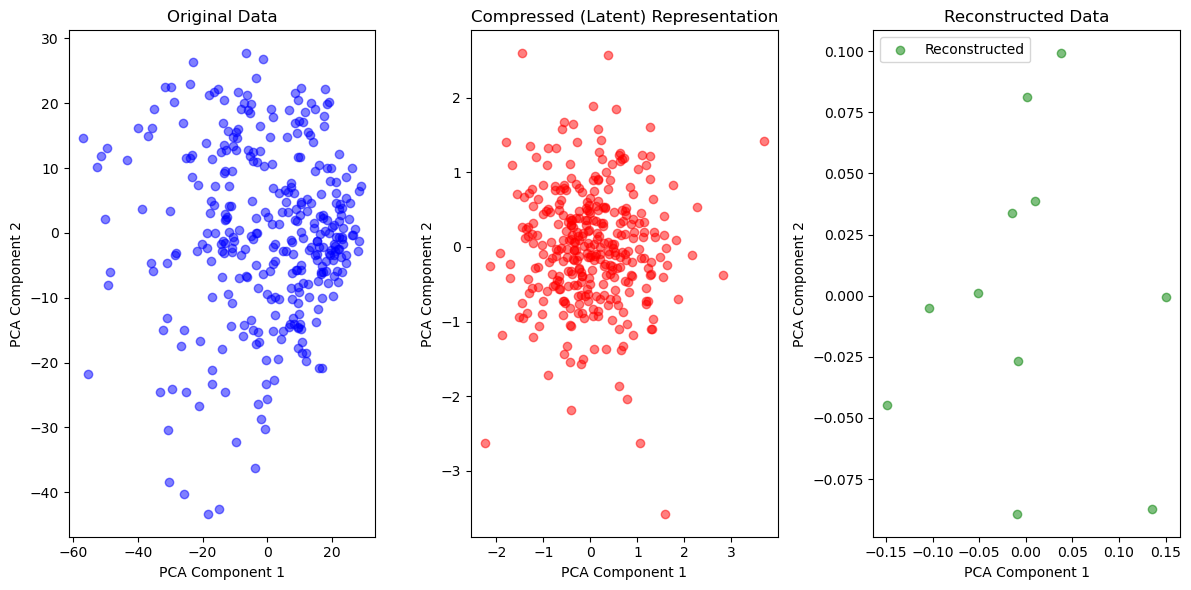

In [169]:
from sklearn.decomposition import PCA

pca_original = PCA(n_components=2)
X_2d = pca_original.fit_transform(X_tensor.numpy())

pca_latent = PCA(n_components=2)
mu_2d = pca_latent.fit_transform(mu.numpy())

pca_reconstructed = PCA(n_components=2)
reconstructed_2d = pca_reconstructed.fit_transform(recon_batch.detach().numpy())

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], color='blue', alpha=0.5, label="Original")
plt.title('Original Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 2)
plt.scatter(mu_2d[:, 0], mu_2d[:, 1], color='red', alpha=0.5, label="Compressed")
plt.title('Compressed (Latent) Representation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 3)
plt.scatter(reconstructed_2d[:, 0], reconstructed_2d[:, 1], color='green', alpha=0.5, label="Reconstructed")
plt.title('Reconstructed Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.legend()
plt.show()


In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y = labels
X_train, X_test, y_train, y_test = train_test_split(mu.numpy(), y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.58      0.62        33
           1       0.64      0.74      0.68        34

    accuracy                           0.66        67
   macro avg       0.66      0.66      0.65        67
weighted avg       0.66      0.66      0.65        67



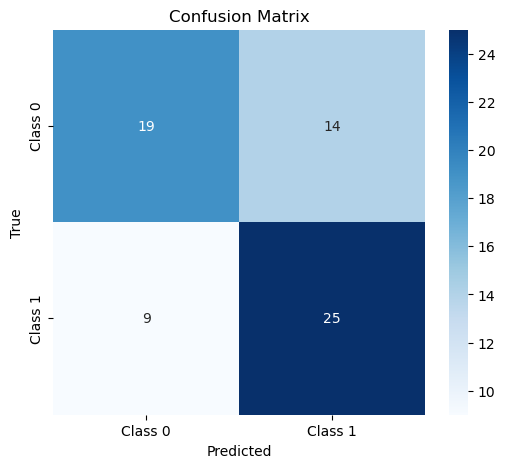

In [179]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        33
           1       0.76      0.82      0.79        34

    accuracy                           0.78        67
   macro avg       0.78      0.78      0.78        67
weighted avg       0.78      0.78      0.78        67



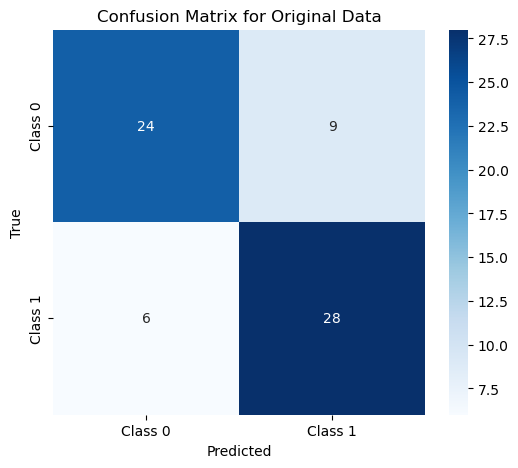

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor.numpy(), labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Original Data')
plt.show()

In [187]:
#Baseline classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

def evaluate_classifiers(X_train, X_test, y_train, y_test):
    results = {}
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[clf_name] = report['accuracy']
        
    return results

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_tensor, y, test_size=0.2, random_state=42)
X_train_recon, X_test_recon, _, _ = train_test_split(mu.numpy(), y, test_size=0.2, random_state=42)

original_results = evaluate_classifiers(X_train_orig, X_test_orig, y_train, y_test)
reconstructed_results = evaluate_classifiers(X_train_recon, X_test_recon, y_train, y_test)

print("Classifier Performance on Original Data:")
for clf, accuracy in original_results.items():
    print(f"{clf}: Accuracy = {accuracy:.4f}")

print("\nClassifier Performance on Reconstructed Data with baseline VAE:")
for clf, accuracy in reconstructed_results.items():
    print(f"{clf}: Accuracy = {accuracy:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier Performance on Original Data:
Logistic Regression: Accuracy = 0.7761
K-Nearest Neighbors: Accuracy = 0.7761
Support Vector Machine: Accuracy = 0.7761
Random Forest: Accuracy = 0.8358
Gradient Boosting: Accuracy = 0.8507

Classifier Performance on Reconstructed Data with baseline VAE:
Logistic Regression: Accuracy = 0.6567
K-Nearest Neighbors: Accuracy = 0.5075
Support Vector Machine: Accuracy = 0.6866
Random Forest: Accuracy = 0.6269
Gradient Boosting: Accuracy = 0.5373
